In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [220]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([-2, 2])
    ax.set_xlim([min(x), max(x)])
    
def plot_activity(activity, data):
    data = data[data['activity'] == activity][:200]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (16, 12), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    fig.suptitle(activity)
    plt.show()

In [221]:
df = read_data('WISDM_ar_v1.1_raw.txt')
df['x-axis'] = feature_normalize(df['x-axis'])
df['y-axis'] = feature_normalize(df['y-axis'])
df['z-axis'] = feature_normalize(df['z-axis'])
df = df.dropna()
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

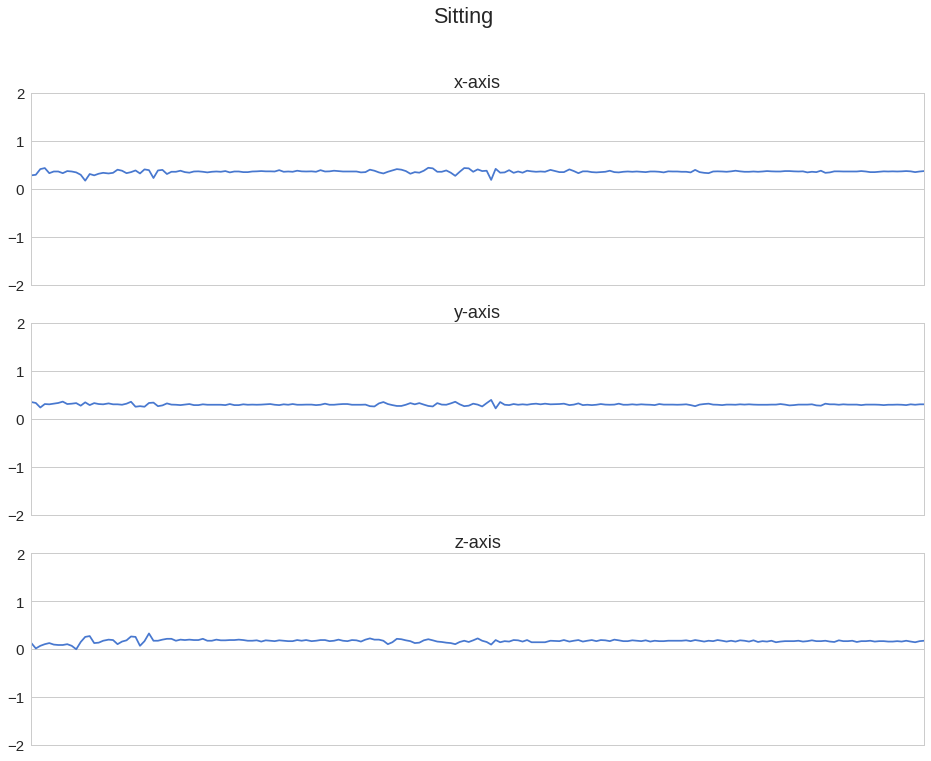

In [222]:
plot_activity("Sitting", df)

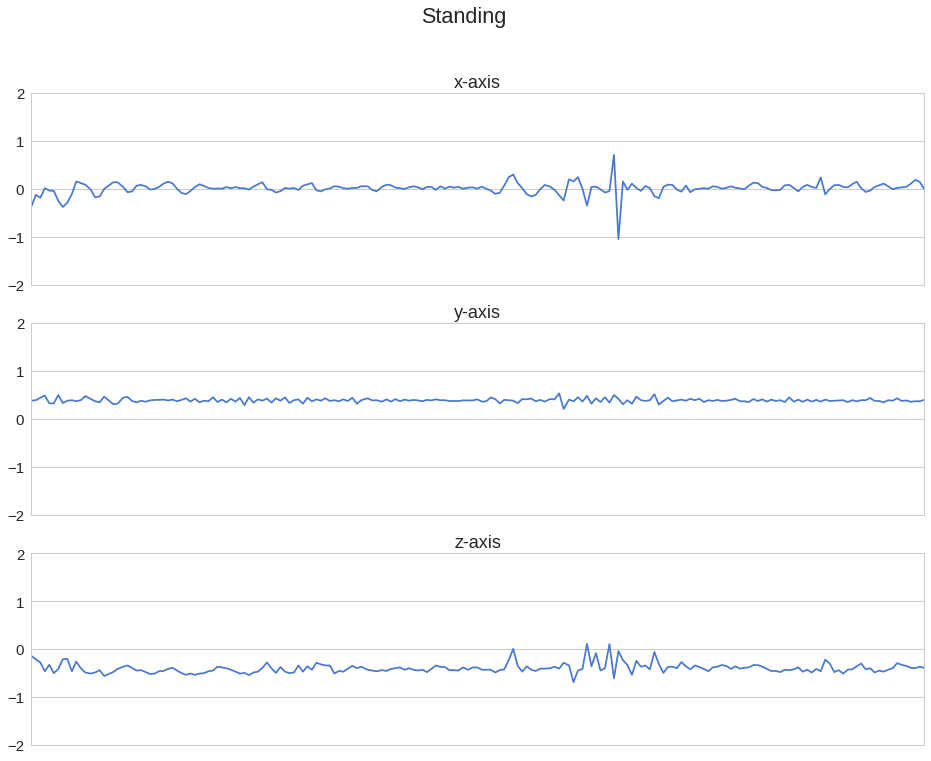

In [203]:
plot_activity("Standing", df)

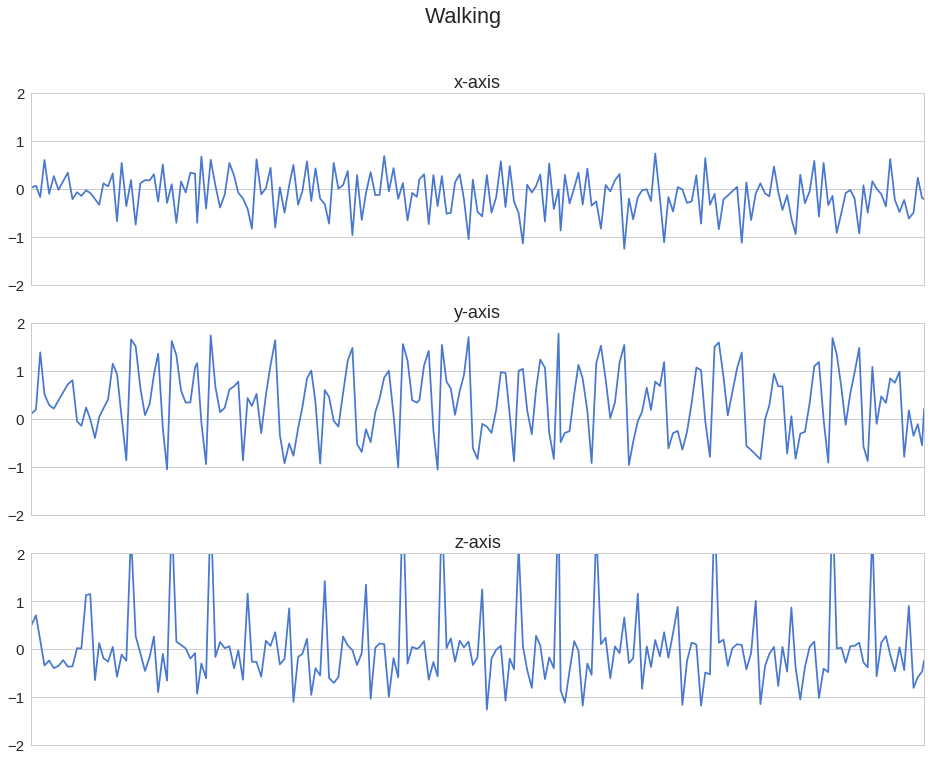

In [204]:
plot_activity("Walking", df)

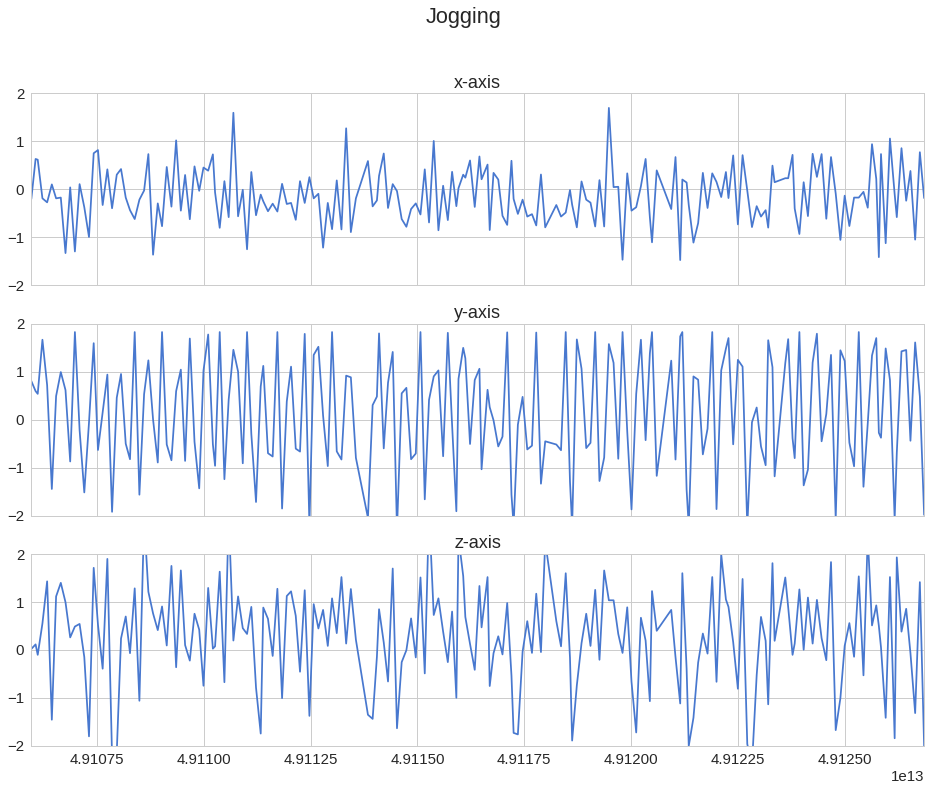

In [171]:
plot_activity("Jogging", df)

In [4]:
SEQUENCE_LENGTH = 200
step = 100
segments = []
labs = []
for i in range(0, len(df) - SEQUENCE_LENGTH, step):
    xs = df['x-axis'].values[i: i + SEQUENCE_LENGTH]
    ys = df['y-axis'].values[i: i + SEQUENCE_LENGTH]
    zs = df['z-axis'].values[i: i + SEQUENCE_LENGTH]
    lbl = stats.mode(df['activity'][i: i + SEQUENCE_LENGTH])[0][0]
#     segments.append(np.dstack([xs, ys, zs]).flatten())
    segments.append([xs, ys, zs])
#     seg.append([xs, ys, zs])
    labs.append(lbl)

/home/vini/.pyenv/versions/3.6.1/envs/teaching/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [5]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, 200, 3)#.reshape(-1, 600, 1) #.reshape(-1, 200, 3)
labels = np.asarray(pd.get_dummies(labs), dtype = np.float32)

In [6]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [43]:
class Config(object):
    """
    define a class to store parameters,
    the input should be feature mat of training and testing
    """

    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 7352 training series
        self.test_data_count = len(X_test)  # 2947 testing series
        self.n_steps = len(X_train[0])  # 128 time_steps per series

        # Trainging
        self.learning_rate = 0.0025
        self.lambda_loss_amount = 0.0015
        self.training_epochs = 100
        self.batch_size = 1024

        # LSTM structure
        self.n_inputs = len(X_train[0][0])  # Features count is of 9: three 3D sensors features over time
        self.n_hidden = 32  # nb of neurons inside the neural network
        self.n_classes = 6  # Final output classes
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))
        }
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))
        }


def LSTM_Network(feature_mat, config):
    """model a LSTM Network,
      it stacks 2 LSTM layers, each layer has n_hidden=32 cells
       and 1 output layer, it is a full connet layer
      argument:
        feature_mat: ndarray fature matrix, shape=[batch_size,time_steps,n_inputs]
        config: class containing config of network
      return:
              : matrix  output shape [batch_size,n_classes]
    """
    # Exchange dim 1 and dim 0
    feature_mat = tf.transpose(feature_mat, [1, 0, 2])
    # New feature_mat's shape: [time_steps, batch_size, n_inputs]

    # Temporarily crush the feature_mat's dimensions
    feature_mat = tf.reshape(feature_mat, [-1, config.n_inputs])
    # New feature_mat's shape: [time_steps*batch_size, n_inputs]

    # Linear activation, reshaping inputs to the LSTM's number of hidden:
    hidden = tf.nn.relu(tf.matmul(
        feature_mat, config.W['hidden']
    ) + config.biases['hidden'])
    # New feature_mat (hidden) shape: [time_steps*batch_size, n_hidden]

    # Split the series because the rnn cell needs time_steps features, each of shape:
    hidden = tf.split(hidden, config.n_steps, 0)
    # New hidden's shape: a list of lenght "time_step" containing tensors of shape [batch_size, n_hidden]

    # Define LSTM cell of first hidden layer:
    # lstm_cell = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0)

    # # Stack two LSTM layers, both layers has the same shape
    # lsmt_layers = tf.contrib.rnn.MultiRNNCell([lstm_cell] * 2)


    lsmt_layers = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0) for _ in range(2)])

    # Get LSTM outputs, the states are internal to the LSTM cells,they are not our attention here
    outputs, _ = tf.contrib.rnn.static_rnn(lsmt_layers, hidden, dtype=tf.float32)

    # outputs' shape: a list of lenght "time_step" containing tensors of shape [batch_size, n_classes]

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']

#     #-----------------------------------
#     # step2: define parameters for model
#     #-----------------------------------
tf.reset_default_graph()
config = Config(train_x, test_x)
#     print("Some useful info to get an insight on dataset's shape and normalisation:")
#     print("features shape, labels shape, each features mean, each features standard deviation")
#     print(X_test.shape, y_test.shape,
#           np.mean(X_test), np.std(X_test))
#     print("the dataset is therefore properly normalised, as expected.")

    #------------------------------------------------------
    # step3: Let's get serious and build the neural network
    #------------------------------------------------------
X = tf.placeholder(tf.float32, [None, config.n_steps, config.n_inputs], name="input")
Y = tf.placeholder(tf.float32, [None, config.n_classes])

pred_Y = LSTM_Network(X, config)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

# Loss,optimizer,evaluation
l2 = config.lambda_loss_amount * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
# Softmax loss and L2
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

optimizer = tf.train.AdamOptimizer(
    learning_rate=config.learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [44]:
saver = tf.train.Saver()

train_loss = []
train_acc = []
test_loss = []
test_acc = []

with tf.Session() as sess:

# sess=tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    tf.global_variables_initializer().run()

#     best_accuracy = 0.0
    # Start training for each batch and loop epochs
    for i in range(config.training_epochs):
        for start, end in zip(range(0, config.train_count, config.batch_size),
                              range(config.batch_size, config.train_count + 1, config.batch_size)):
            sess.run(optimizer, feed_dict={X: train_x[start:end],
                                           Y: train_y[start:end]})
        
        
        _, acc_train, loss_train = sess.run([pred_softmax, accuracy, cost], feed_dict={
                                                X: train_x, Y: train_y})
        
        # Test completely at every epoch: calculate accuracy
        _, acc_test, loss_test = sess.run([pred_softmax, accuracy, cost], feed_dict={
                                                X: test_x, Y: test_y})
        
        if i % 10 != 0:
            continue

    #     print(pred_out)
        print("traing iter: {},".format(i)+\
              " test accuracy : {},".format(acc_test)+\
              " loss : {}".format(loss_test))
        
        train_loss.append(loss_train)
        train_acc.append(acc_train)
        test_loss.append(loss_test)
        test_acc.append(acc_test)
#         best_accuracy = max(best_accuracy, accuracy_out)

#     print("")
#     print("final test accuracy: {}".format(accuracy_out))
#     print("best epoch's test accuracy: {}".format(best_accuracy))
#     print("")
    tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
    saver.save(sess, save_path = "./checkpoint/har.ckpt")

traing iter: 0, test accuracy : 0.516897976398468, loss : 1.7730768918991089
traing iter: 10, test accuracy : 0.7435123920440674, loss : 1.1264495849609375
traing iter: 20, test accuracy : 0.8035606145858765, loss : 0.9246603846549988
traing iter: 30, test accuracy : 0.7830417156219482, loss : 0.9606037139892578
traing iter: 40, test accuracy : 0.840977668762207, loss : 0.7825573682785034
traing iter: 50, test accuracy : 0.8355461359024048, loss : 0.7743234634399414
traing iter: 60, test accuracy : 0.8696438670158386, loss : 0.6928111910820007
traing iter: 70, test accuracy : 0.8608931303024292, loss : 0.7159410715103149
traing iter: 80, test accuracy : 0.8823174238204956, loss : 0.6459628343582153
traing iter: 90, test accuracy : 0.8889559507369995, loss : 0.6117993593215942


In [45]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./checkpoint/har.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoint/'))
    predictions, accuracy_out, loss_out = sess.run([pred_softmax, accuracy, cost], feed_dict={X: test_x, Y: test_y})
    
    print("test accuracy : {},".format(accuracy_out)+\
              " loss : {}".format(loss_out))

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
test accuracy : 0.8928786516189575, loss : 0.5993707180023193


In [23]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
6850 ops in the final graph.


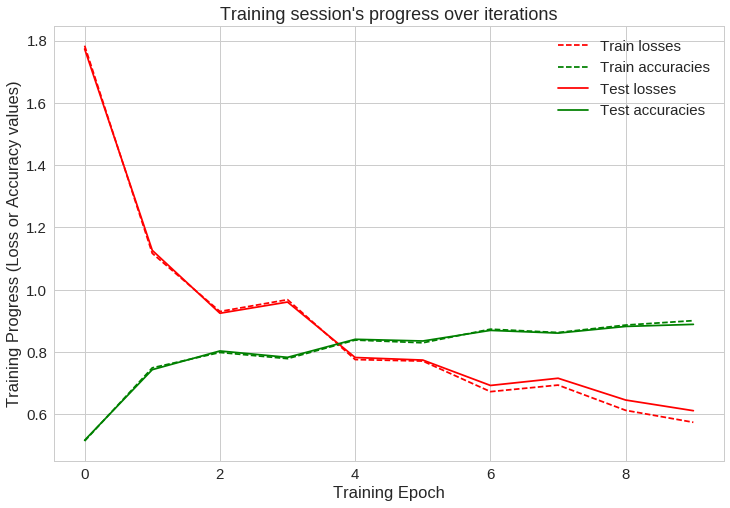

In [91]:
width = 12
height = 8
plt.figure(figsize=(width, height))

# indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(np.array(train_loss), "r--", label="Train losses")
plt.plot(np.array(train_acc), "g--", label="Train accuracies")

plt.plot(np.array(test_loss), "r-", label="Test losses")
plt.plot(np.array(test_acc), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')

plt.show()

In [56]:
max_pred = np.argmax(predictions, axis=1)
max_test = np.argmax(test_y, axis=1)

In [63]:
confusion_matrix = metrics.confusion_matrix(max_test, max_pred)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

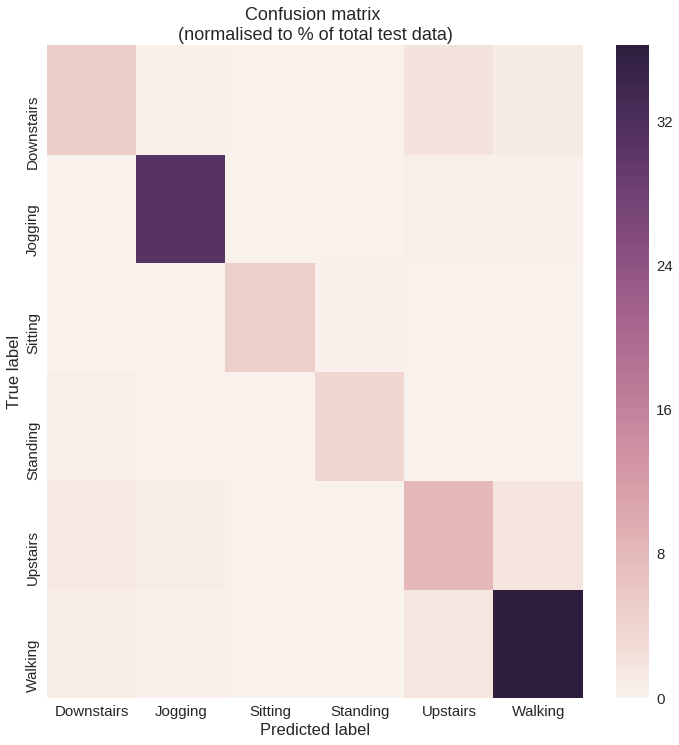

In [85]:
width = 12
height = 12
plt.figure(figsize=(width, height))
sns.heatmap(normalised_confusion_matrix, xticklabels=LABELS, yticklabels=LABELS);
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()